# GPU Environment Preparation

In [2]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a4474627-ae84-43cf-4b1a-0c102e2d0140)


In [1]:
#%rm -rf /content/train
#%rm -rf /content/test
#%rm -rf /content/keras-retinanet

In [3]:
import sys
print(f"Python {sys.version}\n")

import numpy as np
print(f"NumPy {np.__version__}\n")

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow detected {len(gpus)} GPU(s):")
for i, gpu in enumerate(gpus):
  print(f".... GPU No. {i}: Name = {gpu.name}, Type = {gpu.device_type}")

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0, Type = GPU


In [4]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# Import Libraries

In [5]:
!pip install keras_retinanet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# show images inline
%matplotlib inline

import keras
import tensorflow

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

#Clone Git Repository
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!python setup.py build_ext --inplace

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet import models

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (4205/4205), done.
/content/keras-retinanet
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/ker

# Creating CSV for Training

In [7]:
dir_train = '/content/train/'
df_extrain_main = pd.read_csv(dir_train + '_annotations.csv', header=None)
df_extrain_main[0] = dir_train + df_extrain_main[0]
df_extrain_main.columns = ['image_path', 'x', 'y', 'width', 'height', 'class']
df_extrain_main.head()

,image_path,x,y,width,height,class
0,/content/train/img0072_jpg.rf.dca9f8a24a3a21f3...,46,45,334,638,lineman
1,/content/train/GR0009_jpg.rf.e07affcc367ea41f9...,77,63,310,534,grab
2,/content/train/img0011_jpg.rf.da517ad7e1bc5bdc...,42,0,535,640,shopee
3,/content/train/GR0003_jpg.rf.db5404f8a12b86356...,215,149,385,619,grab
4,/content/train/GR0003_jpg.rf.db5404f8a12b86356...,436,163,535,299,grab


In [8]:
classes = pd.DataFrame(df_extrain_main['class'].unique(), columns=['class'])
classes['label'] = range(len(classes))
classes

,class,label
0,lineman,0
1,grab,1
2,shopee,2
3,airasia,3
4,foodpanda,4
5,lazada,5
6,robinhood,6


In [9]:
df_extrain_main.to_csv('annotation.csv', index=False, header=False)
classes.to_csv('classes.csv', index=False, header=False)

# Creating DataFrame for Testing

In [10]:
dir_test = '/content/test/'
df_test = pd.read_csv(dir_train + '_annotations.csv', header=None)
df_test[0] = dir_train + df_test[0]
df_test.columns = ['image_path', 'x', 'y', 'width', 'height', 'class']

# Functions for Mean Average Precision

In [11]:
# compute individual iou
def iou(pred, arr):
  iou = 0

  for actual in arr:
    xlen = min(pred[2], actual[2]) - max(pred[0], actual[0])
    ylen = min(pred[3], actual[3]) - max(pred[1], actual[1])

    if xlen > 0 and ylen > 0:
      area_pred = (pred[2]-pred[0])*(pred[3]-pred[1])
      area_actual = (actual[2]-actual[0])*(actual[3]-actual[1])
      area_intersect = xlen*ylen
      area_union = area_pred + area_actual - area_intersect
      iou = max(iou, area_intersect/area_union)

  return iou


# compute max iou
def max_iou(df_main, img_path, THRES_SCORE):
  ious = [0]*len(classes)

  # actual boxes
  df = df_main[df_main['image_path'] == img_path]

  # predicted boxes
  image = read_image_bgr(img_path)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  boxes /= scale

  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      if score < THRES_SCORE:
          continue
      b = box.astype(int)
      cur_class = classes['class'][label]
      actual_arr = df[df['class'] == cur_class][['x', 'y', 'width', 'height']].to_numpy()
      cur_iou = iou(b, actual_arr)
      if cur_iou > ious[label]:
        ious[label] = cur_iou

  return ious


# report miou dataframe
def report_miou(dir, THRES_SCORE):
  df_main =  pd.read_csv(dir + '_annotations.csv', header=None)
  df_main[0] = dir + df_main[0]
  df_main.columns = ['image_path', 'x', 'y', 'width', 'height', 'class']
  df_miou = df_main[['image_path']]
  miou_list = []

  for i,r in df_main.iterrows():
    miou_list.append(max_iou(df_main, r['image_path'], THRES_SCORE))
  
  for v in classes:
   df_miou[classes['class'].to_list()] = miou_list

  return df_miou


# report average precision
def report_ap(df_miou, iou_arr):
  N = len(df_miou)
  ls = []

  for v in iou_arr:
    ap_arr = [0]*len(classes)
    for i,r in classes.iterrows():
      ap_arr[i] = len(df_miou[df_miou[r['class']] >= v])/N
    ls.append(ap_arr)
  
  df_ap = pd.DataFrame(iou_arr, columns=['iou_thres'])
  df_ap[classes['class'].to_list()] = ls

  return df_ap

# Functions for Plotting

In [12]:
def df_plot_orinal(drawOG,img_path,df):
    df=df[df['image_path']==img_path]
    for i,r in df.iterrows():
        cv2.rectangle(drawOG, (r['x'], r['y']), (r['width'], r['height']), (255,0,0),2)

def img_inference(img_path, THRES_SCORE):
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  drawOG = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  df_plot_orinal(drawOG,img_path,df_extrain_main)
  # correct for image scale
  boxes /= scale
  # visualize detections
  maxscore = 0
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      #print(score)
      if score < THRES_SCORE:
          continue
      else:
        maxscore = max(maxscore, score)
      color = label_color(label)
      b = box.astype(int)
      #print(f"box = {b}, label = {label}, class = {classes[classes['label']==label].iloc[0,0]}, score = {score}")
      draw_box(draw, b, color=color)
      caption = "{} {:.3f}%".format(labels_to_names[label], score*100)

  if maxscore >= THRES_SCORE:  
    fig = plt.figure(figsize=(20, 20))
    ax1=fig.add_subplot(1, 2, 1)
    plt.imshow(draw)
    ax2=fig.add_subplot(1, 2, 2)
    plt.imshow(drawOG)

    ax1.title.set_text('Predicted')
    ax2.title.set_text('Actual')
    plt.show()

# Download Pretrained Weights

In [13]:
!pip install --upgrade git+https://github.com/broadinstitute/keras-resnet
import keras
import keras_resnet
import urllib.request
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/broadinstitute/keras-resnet to /tmp/pip-req-build-u3zjijl2
  Running command git clone -q https://github.com/broadinstitute/keras-resnet /tmp/pip-req-build-u3zjijl2
Downloaded pretrained model to ./snapshots/_pretrained_model.h5


# Training RetinaNet

In [14]:
import os
lst = os.listdir('/content/train/') # your directory path
len(lst) - 1

552

In [15]:
THRES_SCORE = 0.09  # Set Score Threshold Value
iou_arr = [0.1*i for i in range(1,10)]
dir_test = '/content/test/'

## Freeze Backbone

In [15]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 69 --epochs 2 csv annotation.csv classes.csv

model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv('classes.csv',header=None).T.loc[0].to_dict()

Creating model, this may take a second...
2022-10-19 15:07:38.348627: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)           

In [16]:
df_miou = report_miou(dir_test, THRES_SCORE)
df_ap = report_ap(df_miou, iou_arr)
ap_class = df_ap.mean()[1:]
print(ap_class)
mean_ap = ap_class.mean()
print(mean_ap)

lineman      0.000000
grab         0.060606
shopee       0.000000
airasia      0.000000
foodpanda    0.500000
lazada       0.000000
robinhood    0.186869
dtype: float64
0.10678210678210677


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


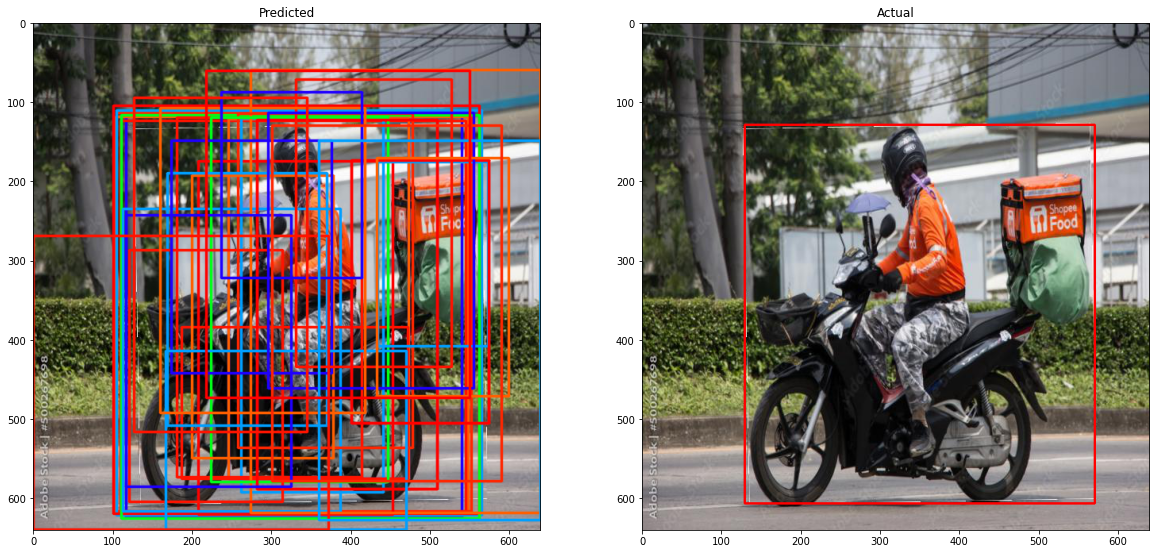

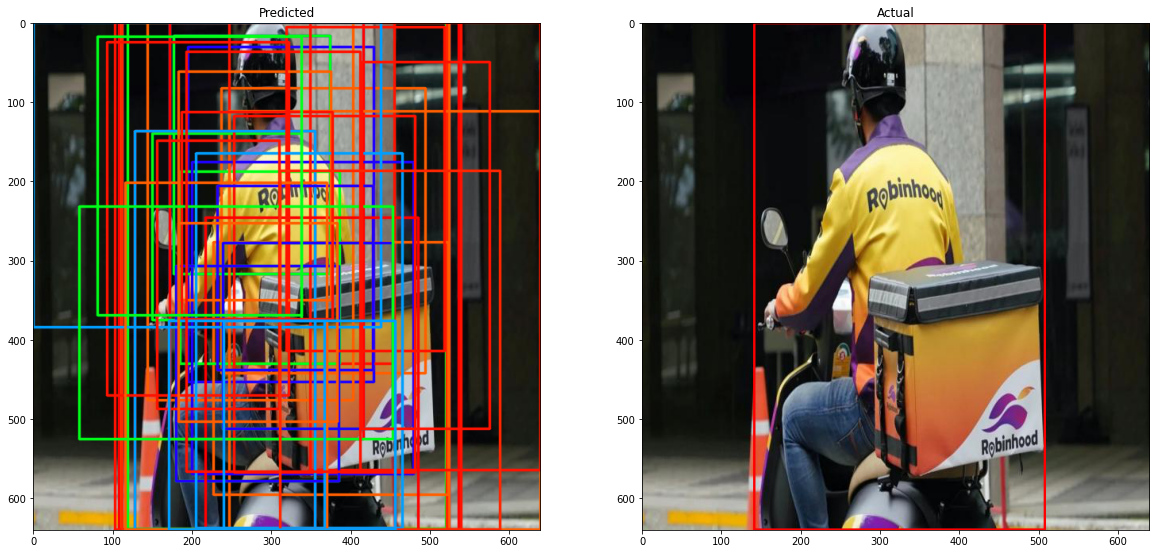

In [17]:
data = df_test.sample(n=2)  #Predict on Random 2 Image
for i,r in data.iterrows():
    img_inference(r['image_path'], THRES_SCORE)
    print("\n\n\n")

## Unfreeze Backbone

In [16]:
!keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 69 --epochs 2 csv annotation.csv classes.csv

model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')  ## Use backbone as resnet50
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv('classes.csv',header=None).T.loc[0].to_dict()

Creating model, this may take a second...
2022-10-19 15:16:24.539046: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)           

In [17]:
df_miou = report_miou(dir_test, THRES_SCORE)
df_ap = report_ap(df_miou, iou_arr)
ap_class = df_ap.mean()[1:]
print(ap_class)
mean_ap = ap_class.mean()
print(mean_ap)

lineman      0.000000
grab         0.070707
shopee       0.000000
airasia      0.000000
foodpanda    0.500000
lazada       0.000000
robinhood    0.242424
dtype: float64
0.11616161616161616


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


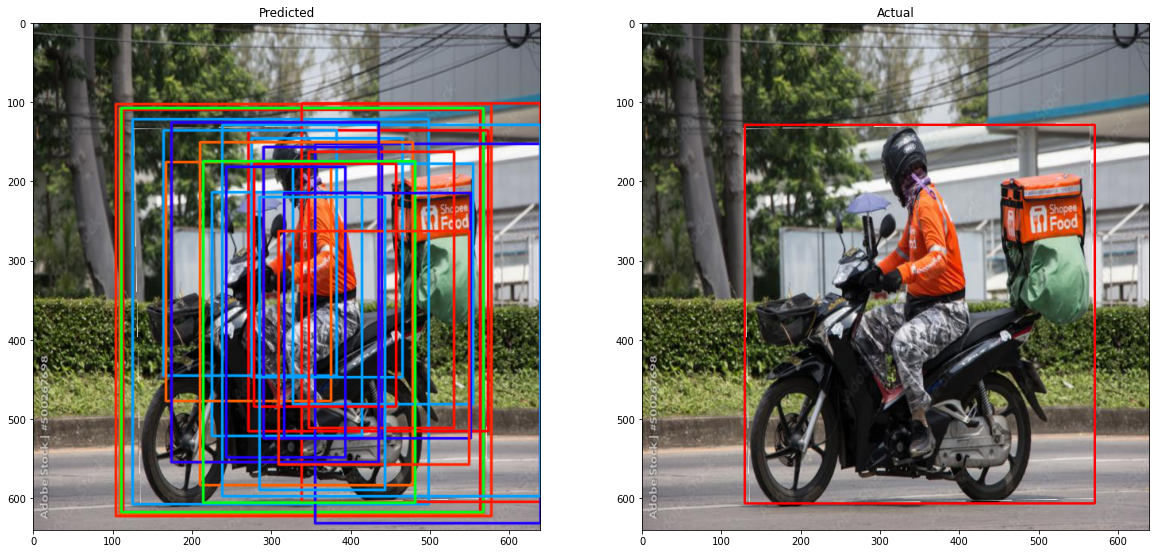

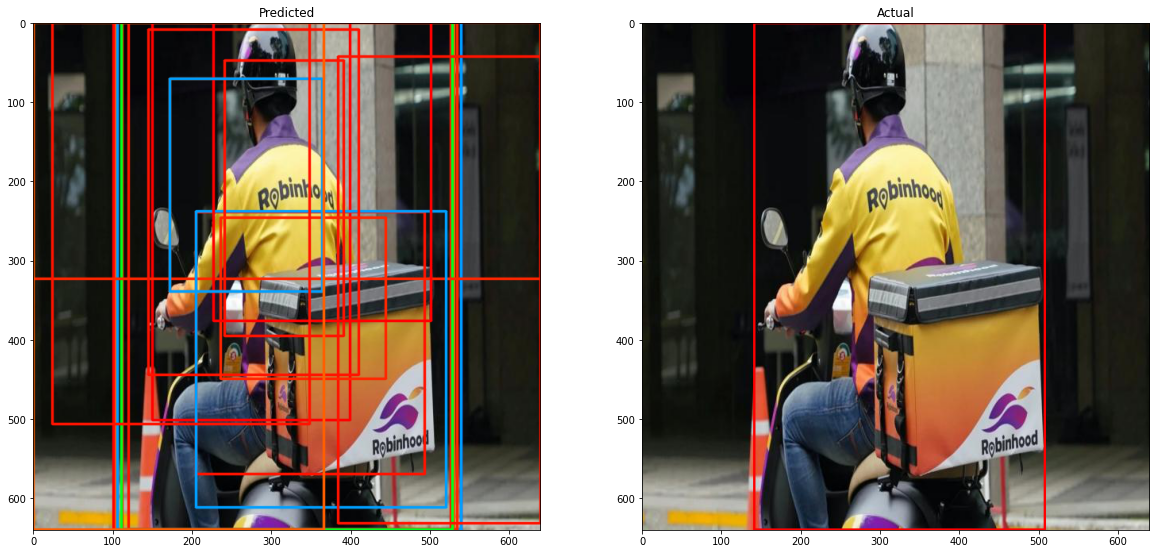

In [18]:
data=df_test.sample(n=2)  #Predict on Random 2 Image
for i,r in data.iterrows():
    img_inference(r['image_path'], THRES_SCORE)
    print("\n\n\n")